##Analyzing Nonprofit Housing Organizations with Pandas

In progress - June 24, 2015

###Table of Contents
* &nbsp;
	* [Analyzing Nonprofit Housing Organizations with Pandas](#Analyzing-Nonprofit-Housing-Organizations-with-Pandas)
		* [Introduction](#Introduction)
		* [Add extensions and import modules](#Add-extensions-and-import-modules)
		* [Ideal way to merge five NCCS files (for years 2009-2013)](#Ideal-way-to-merge-five-NCCS-files-%28for-years-2009-2013%29)
		* [Import data files, add columns, filter, and merge](#Import-data-files,-add-columns,-filter,-and-merge)
		* [Import Merged File](#Import-Merged-File)
		* [Look at Org Data](#Look-at-Org-Data)
			* [Q1: Which organization(s) have the highest (and lowest) income?](#Q1:-Which-organization%28s%29-have-the-highest-%28and-lowest%29-income?)
			* [Q2: How many organizations were founded in 2012?](#Q2:-How-many-organizations-were-founded-in-2012?)
			* [Q3: Using just data from 2013, let's plot when organizations were founded, by decade](#Q3:-Using-just-data-from-2013,-let's-plot-when-organizations-were-founded,-by-decade)
		* [Import Census Bureau data of ~115 most populous cities](#Import-Census-Bureau-data-of-~115-most-populous-cities)
		* [More Groupby operations](#More-Groupby-operations)
			* [Q4: Using the `orgs_cities` dataframe, let's compare the number of organizations, by year, in Durham and other similarly sized cities](#Q4:-Using-the-orgs_cities-dataframe,-let's-compare-the-number-of-organizations,-by-year,-in-Durham-and-other-similarly-sized-cities)
		* [The Power of `unstack`](#The-Power-of-unstack)
		* [Add Dependent Variables](#Add-Dependent-Variables)
		* [Another DV (low-income housing units)](#Another-DV-%28low-income-housing-units%29)
		* [Add GDP Data](#Add-GDP-Data)
		* [Descriptive Statistics (city-level)](#Descriptive-Statistics-%28city-level%29)
		* [Create new dataset of city characterstics (like the `collapse` command in Stata)](#Create-new-dataset-of-city-characterstics-%28like-the-collapse-command-in-Stata%29)
		* [Comparable Stata code](#Comparable-Stata-code)


###Introduction

This is a brief tutorial of how to work with the pandas library in Python to import datasets, clean and merge them together, get some descriptive statistics, and (in progress) do some statistical analysis. 

I started using pandas when I realized that I wanted to merge a lot of large datasets together for a research project I'm working on. My basic research question is to see whether the presence of nonprofit organizations that work in any capacity on affordable housing has an effect on affordable housing policies and outcomes.

For this project, the data I'm using for nonprofit organizational presence come from the IRS (and compiled by the National Center for Charitable Statistics. The data for my outcomes of interest -- housing voucher usage and the number of affordable housing units built -- come from the U.S. Department of Housing and Urban Development (HUD). I also use data from the Census Bureau and the Bureau of Economic Analysis.

The city is my unit of analysis.

A big chunk of this notebook deals with importing and merging datasets to get the data ready for analysis.

###Add extensions and import modules

If you want to load the JS extensions (spell check for markdown and table of contents creation), check out http://calicoproject.org/Icalico and https://github.com/minrk/ipython_extensions. 

In [3]:
%%javascript
IPython.load_extensions('toc', 'calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

In [3]:
# Import modules and set display settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.set_option('display.width', 5000) 
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.max_columns', 100)

In [4]:
%matplotlib inline

In [5]:
#download style sheets here: https://github.com/brandon-rhodes/pycon-pandas-tutorial

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

###Ideal way to merge five NCCS files (for years 2009-2013)

Each of the NCCS yearly files I downloaded (which, unfortunately, are not freely available) contained about a million records (and approximately 60 variables). Each row contains information about a registered nonprofit organization in the U.S., including year of founding (or, more accurately, year the IRS approved nonprofit status), annual income, location, and an NTEE code (classification of an organization's main activity). For more, see http://www.irs.gov/pub/irs-soi/eo_info.pdf. 

Each file was about 500 MB, so merging five of them in the function below was too much for my computer. So, I narrowed down each file (i.e., data for each year) to the kinds of organizations I was interested in.

Don't execute first cell below...it has either taken too long or crashed my browser

In [ ]:
# Import organization text files and append to a list
# Data from 2009 from October, not December

years = range(2009, 2014)
pieces = []

for year in years:
    path = 'C:\Users\Akram Al-Turk\Box Sync\MA data\Org_data\eo_te\eo_12_%d.txt' % year
    eo = pd.read_csv(path)  
    eo['year'] = year
    #eo['month'] = month
    pieces.append(eo)

# Concatenate all orgs into one DF

eos = pd.concat(pieces, ignore_index=True)

#

eos['city_lower'] = eos.CITY.str.lower()
eos['state_lower'] = eos.STATE.str.lower()

eos['housing_in_name'] = eos.NAME.str.contains('HOUSING COALITION') | eos.NAME.str.contains('FAIR HOUSING') | eos.NAME.str.contains('AFFORDABLE HOUSING') 
eos['housing_activ'] = ((eos.ACTIV2 >= 380) & (eos.ACTIV2 <= 399)) | ((eos.ACTIV1 >= 380) & (eos.ACTIV1 <= 399)) | ((eos.ACTIV3 >= 380) & (eos.ACTIV3 <= 399))
eos['housing_ntee'] = eos.NTEE1 == 'L'
eos['housing_other'] = (eos.ACTIV1 == 402) | (eos.ACTIV1 == 429) | (eos.ACTIV2 == 402) | (eos.ACTIV2 == 429) | (eos.ACTIV3 == 402) | (eos.ACTIV3 == 429)

eos['all_housing'] = (eos.housing_in_name == True) | (eos.housing_activ == True) | (eos.housing_ntee == True) | (eos.housing_other == True)

###Import data files, add columns, filter, and merge

This code is more inefficient, but ultimately works better for me.

First, let's import one of the data files and read it into a pandas dataframe.

In [7]:
orgs_13_loc = r'C:\Users\Akram Al-Turk\Box Sync\MA data\Org_data\eo_te\eo_12_2013.txt'
orgs_13 = pd.read_csv(orgs_13_loc)

C:\Users\Akram Al-Turk\Anaconda\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


There are a number of commands that you can use to inspect the data. I'll go through a few them throughout. 

This one is to look at a list of variable names in the dataset.

In [8]:
orgs_13.columns

Index([u'EIN', u'NAME', u'STATE', u'NTEE1', u'NTEECC', u'ADDRESS', u'CITY', u'ZIP', u'zip5', u'FIPS', u'MSA_NECH', u'PMSA', u'TAXPER', u'outnccs', u'OUTREAS', u'Filer', u'ZFILER', u'SUBSECCD', u'ntmaj5', u'ntmaj10', u'ntmaj12', u'NTEEconf', u'MAJGRPB', u'ACTIV1', u'ACTIV2', u'ACTIV3', u'ASCD', u'INCCD', u'INCOME', u'F990REV', u'ASSETS', u'cFiler', u'czFiler', u'cTaxPer', u'cTotRev', u'cAssets', u'cFinSrc', u'RULEDATE', u'FNDNCD', u'FRCD', u'AFCD', u'ARED', u'CONTACT', u'SEC_NAME', u'GEN', u'EOSTATUS', u'LEVEL1', u'LEVEL2', u'level3', u'level4', u'CLASSCD', u'DEDUCTCD', u'NTEEIRS', u'NAICS', u'ORGCD', u'ACCPER'], dtype='object')

And now just looking at the first five rows in the dataset.

In [9]:
orgs_13.head()

,EIN,NAME,STATE,NTEE1,NTEECC,ADDRESS,CITY,ZIP,zip5,FIPS,MSA_NECH,PMSA,TAXPER,outnccs,OUTREAS,Filer,ZFILER,SUBSECCD,ntmaj5,ntmaj10,ntmaj12,NTEEconf,MAJGRPB,ACTIV1,ACTIV2,ACTIV3,ASCD,INCCD,INCOME,F990REV,ASSETS,cFiler,czFiler,cTaxPer,cTotRev,cAssets,cFinSrc,RULEDATE,FNDNCD,FRCD,AFCD,ARED,CONTACT,SEC_NAME,GEN,EOSTATUS,LEVEL1,LEVEL2,level3,level4,CLASSCD,DEDUCTCD,NTEEIRS,NAICS,ORGCD,ACCPER
0,19818,PALMER SECOND BAPTIST CHURCH,MA,X,X21,1050 THORNDIKE ST,PALMER,01069-1507,1069,25013,8003,NaN,NaN,IN,NaN,N,N,3,OT,RE,RE,A,X,1,0,0,0,0,0,0,0,N,N,.,.,.,.,195504,10,60,9,0,NaN,3514,3125,1,PC,O,RE,X,7,1,NaN,813110,5,12
1,29215,ST GEORGE CATHEDRAL,MA,X,X20,523 E BROADWAY,SOUTH BOSTON,02127-4415,2127,25025,1123,NaN,NaN,IN,NaN,N,N,3,OT,RE,RE,C,X,1,0,0,0,0,0,0,0,N,N,.,.,.,.,197210,10,60,9,0,NaN,NaN,2365,1,PC,O,RE,X,7,1,NaN,813110,1,12
2,260049,CORINTH BAPTIST CHURCH,FL,X,X21,PO BOX 92,HOSFORD,32334-0092,32334,12077,NaN,NaN,NaN,IN,NaN,N,N,3,OT,RE,RE,A,X,59,29,0,0,0,0,0,0,N,N,.,.,.,.,196908,10,60,9,0,NaN,NaN,2024,1,PC,O,RE,X,7,1,NaN,813110,5,12
3,262650,THE SOCIETY OF ST VINCENT DE PAUL OF MEMPHIS INC,TN,T,T30,3522 CARNES AVE,MEMPHIS,38111-5704,38111,47157,4920,NaN,NaN,IN,NaN,N,N,3,OT,PU,PU,B,T,0,0,0,0,0,0,0,0,N,N,.,.,.,.,201304,15,10,3,0,NaN,NaN,0,1,PC,S,ZD,T,1,1,T30,813211,1,12
4,490336,EASTSIDE BAPTIST CHURCH,FL,X,X21,PO BOX 296,LABELLE,33975-0296,33975,12051,NaN,NaN,NaN,IN,NaN,N,N,3,OT,RE,RE,A,X,59,29,0,0,0,0,0,0,N,N,.,.,.,.,196908,10,60,9,0,NaN,NaN,2024,1,PC,O,RE,X,7,1,NaN,813110,5,12


Because there are a lot of variables I'm not going to use, I can just specify which ones I want.

In [9]:
variables = ['EIN', 'NAME', 'NTEE1', 'NTEECC', 'CITY', 'STATE', 'zip5', 'MSA_NECH', 'ntmaj12', 'ACTIV1', 'ACTIV2', 'ACTIV3', 'INCOME', 'ASSETS', 'RULEDATE', 'NTEEIRS', 'NAICS']

Then, I create a new dataframe that includes just my variables.

I also create a few new variables. I want to add a 'year' variable, since I'll be working with five years worth of data. 

I then use a few string commands (see [Working with Text Data](http://pandas.pydata.org/pandas-docs/stable/text.html)). 

A couple of them are just to create new variables that use lower case for the city and state. I'll need this later when I merge in other datasets. 

Based on the IRS file I linked to above, there are a few ways we can narrow down our dataframe to include organizations that work on affordable housing. (This definitely has its limitations.) "L" groups are classified as "Housing, Shelter" and then there are some activity codes that correspond to housing-based work. 

In [10]:
orgs_13 = orgs_13[variables]
orgs_13['year'] = 2013

orgs_13['city_lower'] = orgs_13.CITY.str.lower()
orgs_13['state_lower'] = orgs_13.STATE.str.lower()

orgs_13['housing_in_name'] = orgs_13.NAME.str.contains('HOUSING COALITION') | orgs_13.NAME.str.contains('FAIR HOUSING') | orgs_13.NAME.str.contains('AFFORDABLE HOUSING') 
orgs_13['housing_activ'] = ((orgs_13.ACTIV2 >= 380) & (orgs_13.ACTIV2 <= 399)) | ((orgs_13.ACTIV1 >= 380) & (orgs_13.ACTIV1 <= 399)) | ((orgs_13.ACTIV3 >= 380) & (orgs_13.ACTIV3 <= 399))
orgs_13['housing_ntee'] = orgs_13.NTEE1 == 'L'
orgs_13['housing_other'] = (orgs_13.ACTIV1 == 402) | (orgs_13.ACTIV1 == 429) | (orgs_13.ACTIV2 == 402) | (orgs_13.ACTIV2 == 429) | (orgs_13.ACTIV3 == 402) | (orgs_13.ACTIV3 == 429)

We can look at the shape of the dataset. After I included just the variables I was interested in and adding a few, it looks like we now have 25 columns. And approximately 1 million rows.

In [2]:
orgs_13.shape

NameError: name 'orgs_13' is not defined

The code above just added (or removed) columns. It didn't filter out any records. The syntax in pandas sometimes confuses me, and this took me a few tries. You often have to write `df[(df.variable...)]` to get that subset of the dataframe. The code above didn't have this df followed by df that I have below.

In [14]:
housing_orgs_13 = orgs_13[(orgs_13.housing_in_name == True) | (orgs_13.housing_activ == True) | (orgs_13.housing_ntee == True) | (orgs_13.housing_other == True)]

As we can see from the `shape` command, the code just above this one gave us a new df, which now has 34522 rows.

In [15]:
housing_orgs_13.shape

(34522, 25)

Or about 3 percent of all registered nonprofit organizations in the U.S.

In [41]:
"%.3f" % (34522/float(1047591))

'0.033'

###Import Merged File

After running the code above on the five files (one each for 2009-2013), I merged the five resulting dataframes. 

Here's how to do that:
```
housing_orgs_5yrs = pd.concat([housing_orgs_13, housing_orgs_12, housing_orgs_11, housing_orgs_10, housing_orgs_09])
```

Then, export to a csv file:
```
housing_orgs_5yrs.to_csv('C:\Users\Akram Al-Turk\Box Sync\MA data\housing_orgs_5yrs.csv')
```

In [6]:
#import merged file
housing_orgs_location = r'C:\Users\Akram Al-Turk\Box Sync\MA data\housing_orgs_5yrs.csv'
housing_orgs_5yrs = pd.read_csv(housing_orgs_location)

C:\Users\Akram Al-Turk\Anaconda\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


###Look at Org Data

In [11]:
housing_orgs_5yrs.shape

(189756, 26)

We see we have 189,756 organization-year observations.

In [89]:
# top of dataframe

housing_orgs_5yrs.head()

,Unnamed: 0,EIN,NAME,NTEE1,NTEECC,CITY,STATE,zip5,MSA_NECH,ntmaj12,ACTIV1,ACTIV2,ACTIV3,INCOME,ASSETS,RULEDATE,NTEEIRS,NAICS,year,month,city_lower,state_lower,housing_in_name,housing_activ,housing_ntee,housing_other
0,29,10024907,BAR HARBOR VILLAGE IMPROVEMENT ASSOCIATION,S,S20,BAR HARBOR,ME,4609,NaN,PU,402,404,0,42247,612052,199603,S20Z,813410,2013,12,bar harbor,me,False,False,False,True
1,35,10131950,PLANT MEMORIAL HOME,A,A80,BATH,ME,4530,NaN,AR,382,0,0,1790944,4500326,197202,NaN,712120,2013,12,bath,me,False,True,False,False
2,74,10211504,EUNICE FRYE HOME,L,L99,PORTLAND,ME,4112,6403,HU,382,399,0,1264856,1440996,194303,NaN,624220,2013,12,portland,me,False,True,True,False
3,79,10211512,HOME FOR THE AGED,P,P75,PORTLAND,ME,4103,6403,HU,382,0,0,6386270,15951540,194207,P750,623311,2013,12,portland,me,False,True,False,False
4,94,10211545,PORTLAND SEAMENS FRIEND SOCIETY,T,T23,WESTBROOK,ME,4092,6403,PU,399,0,0,102519,172085,195003,NaN,813211,2013,12,westbrook,me,False,True,False,False


In [91]:
#To just view a few columns, use list of lists

housing_orgs_5yrs.head()[['NAME', 'NTEECC', 'RULEDATE', 'city_lower', 'state_lower']]

,NAME,NTEECC,RULEDATE,city_lower,state_lower
0,BAR HARBOR VILLAGE IMPROVEMENT ASSOCIATION,S20,199603,bar harbor,me
1,PLANT MEMORIAL HOME,A80,197202,bath,me
2,EUNICE FRYE HOME,L99,194303,portland,me
3,HOME FOR THE AGED,P75,194207,portland,me
4,PORTLAND SEAMENS FRIEND SOCIETY,T23,195003,westbrook,me


Let's see how many orgs there are per year.

We can use `value.counts` or we can do `groupby` and plot with matplotlib.

There's probably a more efficient way than the plot example below.

In [7]:
print "Housing Orgs by Year\n"

print housing_orgs_5yrs['year'].value_counts()

Housing Orgs by Year

2010    41718
2009    41337
2011    36371
2012    35808
2013    34522
dtype: int64


In [24]:
yearly_counts = housing_orgs_5yrs.groupby('year').EIN.nunique()

In [25]:
yearly_counts

year
2009    41337
2010    41718
2011    36371
2012    35808
2013    34522
Name: EIN, dtype: int64

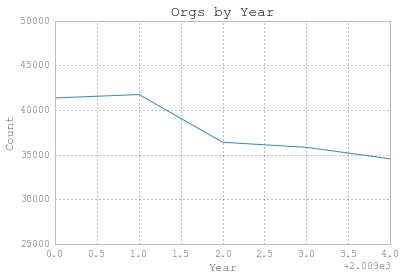

In [36]:
#could be a lot better

yearly_counts.plot()
plt.title("Orgs by Year")
plt.ylabel('Count')
plt.axis([2009, 2013, 25000, 50000])
plt.xlabel('Year')

####Q1: Which organization(s) have the highest (and lowest) income?

####Q2: How many organizations were founded in 2012?

First, let's see which column has this info.

In [14]:
housing_orgs_5yrs.columns

Index([u'Unnamed: 0', u'EIN', u'NAME', u'NTEE1', u'NTEECC', u'CITY', u'STATE', u'zip5', u'MSA_NECH', u'ntmaj12', u'ACTIV1', u'ACTIV2', u'ACTIV3', u'INCOME', u'ASSETS', u'RULEDATE', u'NTEEIRS', u'NAICS', u'year', u'month', u'city_lower', u'state_lower', u'housing_in_name', u'housing_activ', u'housing_ntee', u'housing_other'], dtype='object')

In [20]:
#Let's use RULEDATE

housing_orgs_5yrs.RULEDATE.head()

#Looks like the format is year, month.

0    199603
1    197202
2    194303
3    194207
4    195003
Name: RULEDATE, dtype: int64

In [28]:
founded_12 = housing_orgs_5yrs[(housing_orgs_5yrs.RULEDATE >= 201201) & (housing_orgs_5yrs.RULEDATE <= 201212)]

In [29]:
founded_12.shape

(1662, 26)

In [33]:
len(housing_orgs_5yrs[(housing_orgs_5yrs.RULEDATE >= 201201) & (housing_orgs_5yrs.RULEDATE <= 201212)])

1662

There are a few things to consider about the three cells above. First, remember from above that the syntax to get a dataframe (rather than a bunch of true's and false's) requires putting the name of the dataframe in brackets followed by the variable of interest (I think that both `.variable` and `['variable']` work). The other tricky part is that, although it doesn't seem intuitive, you need to include parentheses when you use operands like `&` and `|`. 

The other thing about that output is that the number of rows (1662) is the organization-year observations, not the number of organizations founded in 2012. How can we find that number?

####Q3: Using just data from 2013, let's plot when organizations were founded, by decade 

In [7]:
#create df with just 2013 data
data_13 = housing_orgs_5yrs[housing_orgs_5yrs.year == 2013]

#double slash cuts off the fraction, so this code will give us the decade of founding
(data_13.RULEDATE // 1000 * 10).head()

#now, let's use value_counts and groupby to plot the results

0    1990
1    1970
2    1940
3    1940
4    1950
Name: RULEDATE, dtype: int64

In [61]:
# value_counts


In [60]:
# groupby


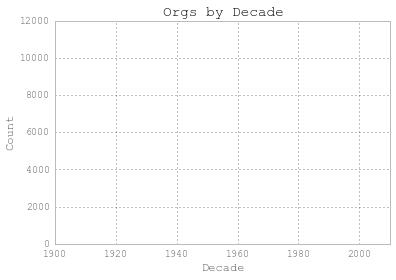

In [68]:
#insert first line of code

plt.title("Orgs by Decade")
plt.ylabel('Count')
plt.axis([1900, 2010, 0, 12000])
plt.xlabel('Decade')

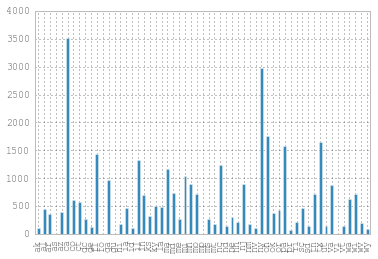

In [14]:
data_13.state_lower.value_counts().sort_index().plot(kind='bar')

###Import Census Bureau data of ~115 most populous cities

This is a file I downloaded from Social Explorer.

In [8]:
# Import city characteristics file (2009-2013)

cities_location = r'C:\Users\Akram Al-Turk\Box Sync\MA Data\census_2009_2013.csv'
cities = pd.read_csv(cities_location)

In [16]:
cities.head(2)

,Year,FIPS,Name of Area,Qualifying Name,State/U.S.-Abbreviation (USPS),Summary Level,Geographic Component,File Identification,Logical Record Number,State (FIPS),Place (FIPS Code),Place (State FIPS + Place FIPS),Metropolitan and Micropolitan Statistical Area,Principal City Indicator,Geographic Identifier,Area (Land),Area (Water),Total Population,Area Total,Area (Land).1,Area (Water).1,Total Population.1,White Alone,Black or African American Alone,American Indian and Alaska Native Alone,Asian Alone,Native Hawaiian and Other Pacific Islander Alone,Some Other Race Alone,Two or More races,Population 16 Years and over,Population 16 Years and over: In labor force,Population 16 Years and over: In labor force: In Armed Forces,Population 16 Years and over: In labor force: Civilian,Population 16 Years and over: In labor force: Civilian: Employed,Population 16 Years and over: In labor force: Civilian: Unemployed,Population 16 Years and over: Not in labor force,Civilian Population In Labor Force 16 Years And Over,Civilian Population In Labor Force 16 Years And Over: Employed,Civilian Population In Labor Force 16 Years And Over: Unemployed,Median household income (In 2013 Inflation adjusted dollars),Households: Gini Index,Housing units,Median year structure built,Owner-occupied housing units: Median value,Renter-occupied housing units,Renter-occupied housing units: Gross Rent As A Percentage Of Household Income In 2011: Less than 10 percent,Renter-occupied housing units: Gross Rent As A Percentage Of Household Income In 2011: 10 to 29 percent,Renter-occupied housing units: Gross Rent As A Percentage Of Household Income In 2011: 30 to 49 percent,Renter-occupied housing units: Gross Rent As A Percentage Of Household Income In 2011: 50 percent or More,Renter-occupied housing units: Gross Rent As A Percentage Of Household Income In 2011: Not computed,Renter-Occupied Paying Cash Rent: Median Gross Rent as a Percentage of Household Income In 2013,Families,Families: Income in 2013 below poverty level,Families: Income in 2013 below poverty level: Married Couple Family: With Related Child Living Bellow Poverty Level,Families: Income in 2013 below poverty level: Married Couple Family: No related children under 18 Years,"Families: Income in 2013 below poverty level: Male Householder, no wife present","Families: Income in 2013 below poverty level: Male Householder, no wife present: With related children under 18 Years","Families: Income in 2013 below poverty level: Male Householder, no wife present: No related children under 18 Years","Families: Income in 2013 below poverty level: Female Householder, no husband present","Families: Income in 2013 below poverty level: Female Householder, no husband present: With related children under 18 Years","Families: Income in 2013 below poverty level: Female Householder, no husband present: No related children under 18 Years",Families: Income in 2013 at or above poverty level,Population Age 18 to 64 for whom poverty status is determined,Population Age 18 to 64 for whom poverty status is determined: Living in Poverty,Population Age 18 to 64 for whom poverty status is determined: At or Above Poverty Level
0,2013,3.640000e+11,"New York city; New York-Newark-Jersey City, NY...","New York city; New York-Newark-Jersey City, Ne...",ny,321,0,ACSSF,26405,36,51000,3651000,35620,Y,32100US363562051000,783842402,429527437,8268999,468.4847,302.6433,165.8415,8268999,3659155,2057226,32421,1077554,4403,1189355,248885,6694673,4244118,3309,4240809,3789820,450989,2450555,4240809,3789820,450989,52259,0.5402,3380513,1948,492800,2080590,98360,823241,476588,581148,101253,31.900000,1844540,318457,73665,41153,28784,19448,9336,174855,138611,36244,1526083,5393156,957146,4436010
1,2013,6.310804e+10,Los Angeles city; Los Angeles-Long Beach-Anahe...,Los Angeles city; Los Angeles-Long Beach-Anahe...,ca,321,0,ACSSF,37860,6,44000,644000,31080,Y,32100US063108044000,NaN,NaN,3827261,NaN,NaN,NaN,3827261,2006054,357932,20424,434846,6924,872000,129081,30

Which cities are in the dataset? 

We can use `unique`.

In [95]:
cities['Name of Area'].unique()

array([ 'New York city; New York-Newark-Jersey City, NY-NJ-PA Metro Area (part); New York',
       'Los Angeles city; Los Angeles-Long Beach-Anaheim, CA Metro Area; California',
       'Chicago city; Chicago-Naperville-Elgin, IL-IN-WI Metro Area (part); Illinois',
       'Houston city; Houston-The Woodlands-Sugar Land, TX Metro Area; Texas',
       'Philadelphia city; Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area (part); Pennsylvania',
       'Phoenix city; Phoenix-Mesa-Scottsdale, AZ Metro Area; Arizona',
       'San Antonio city; San Antonio-New Braunfels, TX Metro Area; Texas',
       'San Diego city; San Diego-Carlsbad, CA Metro Area; California',
       'Dallas city; Dallas-Fort Worth-Arlington, TX Metro Area; Texas',
       'San Jose city; San Jose-Sunnyvale-Santa Clara, CA Metro Area; California',
       'Austin city; Austin-Round Rock, TX Metro Area; Texas',
       'Jacksonville city; Jacksonville, FL Metro Area; Florida',
       'Indianapolis city (balance); Indianapo

Because of how the city names are displayed in this dataset (i.e., differently from the way it is in the Housing Orgs dataframe), I had to create a function that would create a new column. I needed city names without "city" or "municipality" or punctuation. There were a few other issues. 

We need to use the `apply` command to use the function on all cells in the Name of Area column.

In [9]:
def city(text):
    split_text = text.split(';')
    words = split_text[0].split(' ')
    if words[1] == 'municipality' or words[1] == 'city':
        new_city = words[0].lower()
    else:
        new_city = words[0].lower() + ' ' + words[1].lower()
    test_lower = new_city.replace('.', '')
    if test_lower == 'urban honolulu':
        honolulu = test_lower.replace('urban ', '')
        return honolulu
    if test_lower == 'boise city':
        boise = test_lower.replace(' city', '')
        return boise
    if test_lower == 'louisville/jefferson county':
        louisville = test_lower.replace('/jefferson county', '')
        return louisville
    if test_lower == 'lexington-fayette urban':
        lexington = test_lower.replace('-fayette urban', '')
        return lexington
    if test_lower == 'nashville-davidson metropolitan':
        nashville = test_lower.replace('-davidson metropolitan', '')
        return nashville
    if test_lower == 'arlington cdp':
        arlington = test_lower.replace(' cdp', '')
        return arlington
    if test_lower == 'paradise cdp':
        paradise = test_lower.replace(' cdp', '')
        return paradise
    if test_lower == 'honolulu cdp':
        honolulu2 = test_lower.replace(' cdp', '')
        return honolulu2
    if test_lower == 'augusta-richmond county':
        augusta = test_lower.replace('-richmond county', '')
        return augusta
    return test_lower

cities['City Name'] = cities['Name of Area'].apply(city)

In [10]:
cities['City Name'].head()

0        new york
1     los angeles
2         chicago
3         houston
4    philadelphia
Name: City Name, dtype: object

There were about 35-40k orgs per year in the U.S. But because I want to restrict my analysis to cities (and I arbitrarily chose a little over 100), I'd like to just keep the orgs in those cities in my dataset. So, I can use the `merge` function in pandas.

There are different choices you need to make - mostly which columns from each df to merge on and whether to keep observations where there is no match. In this case, I just want to keep orgs in the cities in the second dataframe. So, in the `how` option, I chose `inner` (rather than `outer` or another option). 

In [11]:
orgs_cities = pd.merge(housing_orgs_5yrs, cities, on=None, left_on=['city_lower', 'state_lower', 'year'], right_on=['City Name', 'State/U.S.-Abbreviation (USPS)', 'Year'], how='inner')

In [12]:
orgs_cities.year.value_counts()

2010    13758
2009    13655
2011    11387
2012    11029
2013    10634
dtype: int64

We now have between 10-14k orgs per year.

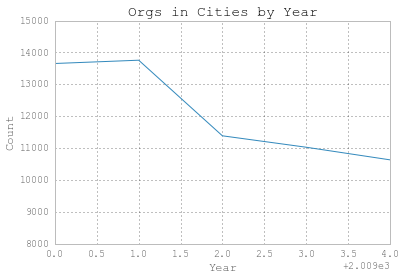

In [47]:
#without sort_index, the plot would order the number of orgs by size, not year

orgs_cities.year.value_counts().sort_index().plot()
plt.title("Orgs in Cities by Year")
plt.ylabel('Count')
plt.axis([2009, 2013, 8000, 15000])
plt.xlabel('Year')

###More Groupby operations 

In [14]:
orgs_cities_13 = orgs_cities[orgs_cities.year == 2013]

orgs_cities_13.groupby(['city_lower', 'state_lower']).size().head(10)

city_lower   state_lower
akron        oh              55
albuquerque  nm              65
anaheim      ca              23
anchorage    ak              31
arlington    tx              11
             va              40
atlanta      ga             263
augusta      ga              36
aurora       co              20
austin       tx             107
dtype: int64

####Q4: Using the `orgs_cities` dataframe, let's compare the number of organizations, by year, in Durham and other similarly sized cities

In [70]:
#Let's start by looking at the populations of cities close in size to Durham (using 2013 data)

orgs_cities_13[['city_lower', 'Total Population', 'Place (State FIPS + Place FIPS)']][orgs_cities_13.city_lower == 'durham'].head(3)

,city_lower,Total Population,Place (State FIPS + Place FIPS)
7790,durham,234922,3719000
7791,durham,234922,3719000
7792,durham,234922,3719000


In [95]:
orgs_cities_13[['city_lower', 'state_lower', 'Total Population', 'Place (State FIPS + Place FIPS)']][(orgs_cities_13['Total Population'] > 180000) 
                                                & (orgs_cities_13['Total Population'] < 300000)]

,city_lower,state_lower,Total Population,Place (State FIPS + Place FIPS)
685,anchorage,ak,295237,203000
686,anchorage,ak,295237,203000
687,anchorage,ak,295237,203000
688,anchorage,ak,295237,203000
689,anchorage,ak,295237,203000
690,anchorage,ak,295237,203000
691,anchorage,ak,295237,203000
692,anchorage,ak,295237,203000
693,anchorage,ak,295237,203000
694,anchorage,ak,295237,203000


In [15]:
#Let's go with Henderson, Irving, and Winston-Salem. We should use their Place code, in case there are other cities in the
# dataset with those names.

#Let's use the five-year dataset.

mid_size = orgs_cities[(orgs_cities['Place (State FIPS + Place FIPS)'] == 4837000) | 
                       (orgs_cities['Place (State FIPS + Place FIPS)'] == 3775000) |
                       (orgs_cities['Place (State FIPS + Place FIPS)'] == 3231900) |
                       (orgs_cities['Place (State FIPS + Place FIPS)'] == 3719000)]

In [16]:
#let's make sure we got our cities.

mid_size.city_lower.unique()

array(['durham', 'henderson', 'winston-salem', 'irving'], dtype=object)

In [49]:
#Need a groupby function that shows city_lower, year, and number of orgs by city
#The output of this code is here to show what this will look like.

#grouped = 

city_lower     Year
durham         2009    59
               2010    62
               2011    52
               2012    50
               2013    45
henderson      2013     7
irving         2009     6
               2010     7
               2011     5
               2012     6
               2013     5
winston-salem  2009     7
               2010     4
               2011     6
               2012     7
               2013     7
dtype: int64

###The Power of `unstack`

The `groupby` function above is nice, but the output isn't great. We can use `unstack` to make it more useful.

We can `unstack` and put the year as the column header or `unstack` and have the cities be column headers.

In [50]:
grouped.unstack()

Year,2009,2010,2011,2012,2013
city_lower,,,,,
durham,59,62,52,50,45
henderson,NaN,NaN,NaN,NaN,7
irving,6,7,5,6,5
winston-salem,7,4,6,7,7


In [51]:
grouped.unstack(0)

city_lower,durham,henderson,irving,winston-salem
Year,,,,
2009,59,NaN,6,7
2010,62,NaN,7,4
2011,52,NaN,5,6
2012,50,NaN,6,7
2013,45,7,5,7


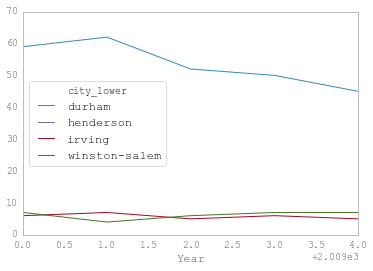

In [52]:
grouped.unstack(0).plot()

###Add Dependent Variables

These data come from HUD, but were compiled by the [Center for Budget and Policy Priorities](http://www.cbpp.org).

I made some slight modifications in Excel (amateur!) before importing.

In [53]:
vouchers_path = r'C:\Users\Akram Al-Turk\Box Sync\MA data\vouchers_cities_2004_2013_edited.csv'
vouchers = pd.read_csv(vouchers_path)

In [54]:
vouchers.head()

,city,note,agency_code,U2004,U2005,U2006,U2007,U2008,HAP2008,U2009,HAP2009,U2010,HAP2010,U2011,HAP2011,U2012,HAP2012,U2013,HAP2013
0,Birmingham,NaN,AL001,102%,83%,84%,80%,79%,"$24,155,820",92%,"$29,902,364",86%,"$30,080,720",87%,"$32,105,898",90%,"$32,636,067",90%,"$32,470,367"
1,Mobile,NaN,AL002,94%,90%,82%,85%,92%,"$18,294,982",87%,"$19,055,258",76%,"$20,685,476",82%,"$23,199,272",77%,"$21,716,235",79%,"$23,441,527"
2,Montgomery,NaN,AL006,83%,79%,64%,66%,68%,"$8,744,545",86%,"$13,193,617",86%,"$13,746,935",100%,"$17,016,581",98%,"$17,284,508",99%,"$17,758,663"
3,Little Rock,NaN,AR004,94%,86%,86%,91%,91%,"$10,730,155",94%,"$10,898,721",93%,"$10,828,313",85%,"$9,745,240",91%,"$10,587,980",87%,"$10,494,708"
4,Glendale,NaN,AZ003,97%,95%,93%,92%,99%,"$7,551,523",97%,"$7,905,111",94%,"$7,771,373",99%,"$8,045,099",99%,"$7,913,603",99%,"$7,799,382"


The data are in wide format, and columns that start with a `U` denote housing voucher usage for that year. To import these data into our master dataframe, I need to convert the voucher dataset to long format.

In [54]:
vouchers['id'] = vouchers.index

In [56]:
vouchers.shape

(104, 20)

In [55]:
vouchers_long = pd.wide_to_long(vouchers, ["U", "HAP"], i="id", j="year")

In [58]:
vouchers_long.shape

(1040, 5)

We went from 104 to 1040 observations.

In [56]:
vouchers_long.head()

,,city,note,agency_code,U,HAP
id,year,,,,,
0,2004,Birmingham,NaN,AL001,102%,NaN
1,2004,Mobile,NaN,AL002,94%,NaN
2,2004,Montgomery,NaN,AL006,83%,NaN
3,2004,Little Rock,NaN,AR004,94%,NaN
4,2004,Glendale,NaN,AZ003,97%,NaN


Need to add some columns to make the data merge-able.

In [57]:
#get state abbreviation from agency code column
# strip out percent sign

vouchers_long['state'] = vouchers_long['agency_code'].str[:2].str.lower()
vouchers_long['city_lower'] = vouchers_long['city'].str.lower()
vouchers_long['voucher_use'] = vouchers_long.U.str[:-1]
vouchers_long['voucher_payments'] = vouchers_long.HAP.str[1:]
vouchers_long['voucher_payments'] = vouchers_long['voucher_payments'].str.replace(',', '')

In [64]:
vouchers_long.head()

,,city,note,agency_code,U,HAP,state,city_lower,voucher_use,voucher_payments
id,year,,,,,,,,,
0,2004,Birmingham,NaN,AL001,102%,NaN,al,birmingham,102,NaN
1,2004,Mobile,NaN,AL002,94%,NaN,al,mobile,94,NaN
2,2004,Montgomery,NaN,AL006,83%,NaN,al,montgomery,83,NaN
3,2004,Little Rock,NaN,AR004,94%,NaN,ar,little rock,94,NaN
4,2004,Glendale,NaN,AZ003,97%,NaN,az,glendale,97,NaN


In [58]:
vouchers_long = vouchers_long.reset_index()

In [59]:
vouchers_long.head()

,id,year,city,note,agency_code,U,HAP,state,city_lower,voucher_use,voucher_payments
0,0,2004,Birmingham,NaN,AL001,102%,NaN,al,birmingham,102,NaN
1,1,2004,Mobile,NaN,AL002,94%,NaN,al,mobile,94,NaN
2,2,2004,Montgomery,NaN,AL006,83%,NaN,al,montgomery,83,NaN
3,3,2004,Little Rock,NaN,AR004,94%,NaN,ar,little rock,94,NaN
4,4,2004,Glendale,NaN,AZ003,97%,NaN,az,glendale,97,NaN


I don't have voucher information on all the cities in my dataframe, but I don't want to delete those cities out (in case I have other useful data later on those cities). 

Because of that, I use `outer` option for `how`.

In [62]:
orgs_vouchers = pd.merge(orgs_cities, vouchers_long, on=None, left_on=['city_lower', 'State/U.S.-Abbreviation (USPS)', 'year'], right_on=['city_lower', 'state', 'year'], how='outer')

###Another DV (low-income housing units)

These data also come from HUD.

In [63]:
lihtc_path = r'C:\Users\Akram Al-Turk\Box Sync\MA data\lihtc_2009_2013.csv'
lihtc = pd.read_csv(lihtc_path)

In [64]:
lihtc['code'].head()

0    200065
1    200650
2    200760
3    200870
4    201090
Name: code, dtype: int64

In [65]:
lihtc['total_units'].isnull().sum()

104688

In [71]:
orgs_vouchers[['city_lower', 'State/U.S.-Abbreviation (USPS)', 'Place (State FIPS + Place FIPS)']].head()

,city_lower,State/U.S.-Abbreviation (USPS),Place (State FIPS + Place FIPS)
0,boston,ma,2507000
1,boston,ma,2507000
2,boston,ma,2507000
3,boston,ma,2507000
4,boston,ma,2507000


In [66]:
orgs_vouchers_lihtc_5yrs = pd.merge(orgs_vouchers, lihtc, on=None, left_on=['Place (State FIPS + Place FIPS)', 'year'], right_on=['code', 'year'], how='inner')

In [67]:
orgs_vouchers_lihtc_5yrs.shape

(60186, 169)

###Add GDP Data

In [68]:
gdp_path = r'C:\Users\Akram Al-Turk\Box Sync\MA data\GDPMetro\allgmp.csv'
gdp_metro = pd.read_csv(gdp_path)

C:\Users\Akram Al-Turk\Anaconda\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (0,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [79]:
gdp_metro.shape

(99714, 21)

In [80]:
gdp_metro.head(4)

,GeoFIPS,GeoName,Region,ComponentId,ComponentName,IndustryId,IndustryClassification,Description,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,998,United States (Metropolitan Portion),NaN,200,GDP by Metropolitan Area (millions of current ...,1,...,All industry total,9578745,9906059,10373523,11059174,11817477,12508774,13075688,13269057,12994636,13461662,13953082,14606938,15079920
1,998,United States (Metropolitan Portion),NaN,200,GDP by Metropolitan Area (millions of current ...,2,...,Private industries,8409914,8667345,9065866,9676986,10367862,10988934,11473021,11584878,11259772,11668693,12140232,12776058,13245359
2,998,United States (Metropolitan Portion),NaN,200,GDP by Metropolitan Area (millions of current ...,3,11,"Agriculture, forestry, fishing, and hunting",53326,52218,60233,72903,66975,69272,74561,75527,70338,79620,93977,94935,124434
3,998,United States (Metropolitan Portion),NaN,200,GDP by Metropolitan Area (millions of current ...,4,111-112,Farms,39710,38540,45753,57952,51874,50788,56231,57231,52069,59873,73198,72478,(NA)


In [69]:
gdp_metro = gdp_metro[gdp_metro.IndustryId == 1]

In [83]:
gdp_metro.head()

,GeoFIPS,GeoName,Region,ComponentId,ComponentName,IndustryId,IndustryClassification,Description,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,998,United States (Metropolitan Portion),NaN,200,GDP by Metropolitan Area (millions of current ...,1,...,All industry total,9578745,9906059,10373523,11059174,11817477,12508774,13075688,13269057,12994636,13461662,13953082,14606938,15079920
87,10180,"Abilene, TX (Metropolitan Statistical Area)",NaN,200,GDP by Metropolitan Area (millions of current ...,1,...,All industry total,3574,3754,4020,4273,4514,4885,5295,5725,5239,5429,5761,6143,6452
174,10420,"Akron, OH (Metropolitan Statistical Area)",NaN,200,GDP by Metropolitan Area (millions of current ...,1,...,All industry total,21646,22742,23744,25217,26649,27418,28177,28663,27761,28616,29425,31012,31485
261,10500,"Albany, GA (Metropolitan Statistical Area)",NaN,200,GDP by Metropolitan Area (millions of current ...,1,...,All industry total,4317,4346,4492,4620,4800,4808,4863,4795,4957,4928,4938,5122,5307
348,10540,"Albany, OR (Metropolitan Statistical Area)",NaN,200,GDP by Metropolitan Area (millions of current ...,1,...,All industry total,2366,2492,2492,2844,2944,3207,3173,3235,3064,3050,3170,3294,3375


In [70]:
gdp_metro_6yrs = pd.melt(gdp_metro, id_vars=['GeoFIPS', 'GeoName'], value_vars=['2008', '2009', '2010', '2011', '2012', '2013'], var_name='year', value_name='GDP')

In [71]:
gdp_metro_6yrs['GDP'] = gdp_metro_6yrs['GDP'].convert_objects(convert_numeric=True)

In [72]:
gdp_metro_6yrs['gdp_growth'] = gdp_metro_6yrs.groupby('GeoFIPS').pct_change()

In [73]:
gdp_metro_6yrs['GeoFIPS'] = gdp_metro_6yrs['GeoFIPS'].convert_objects(convert_numeric=True)

In [74]:
gdp_metro_6yrs['year'] = gdp_metro_6yrs['year'].convert_objects(convert_numeric=True)

In [75]:
gdp_metro_6yrs[gdp_metro_6yrs.GeoName.str.contains("Durham")]

,GeoFIPS,GeoName,year,GDP,gdp_growth
103,20500,"Durham-Chapel Hill, NC (Metropolitan Statistic...",2008,36853,NaN
496,20500,"Durham-Chapel Hill, NC (Metropolitan Statistic...",2009,38700,0.050118
889,20500,"Durham-Chapel Hill, NC (Metropolitan Statistic...",2010,40038,0.034574
1282,20500,"Durham-Chapel Hill, NC (Metropolitan Statistic...",2011,39484,-0.013837
1675,20500,"Durham-Chapel Hill, NC (Metropolitan Statistic...",2012,41366,0.047665
2068,20500,"Durham-Chapel Hill, NC (Metropolitan Statistic...",2013,42245,0.021249


In [76]:
orgs_vouchers_lihtc_gdp_5yrs = pd.merge(orgs_vouchers_lihtc_5yrs, gdp_metro_6yrs, on=None, left_on=['Metropolitan and Micropolitan Statistical Area', 'year'], right_on=['GeoFIPS', 'year'], how='outer')

In [77]:
orgs_vouchers_lihtc_gdp_5yrs.shape

(62423, 173)

###Descriptive Statistics (city-level)

Orgs by city

Org income by city

Org age by city

In [78]:
#create easier name for dataframe

df = orgs_vouchers_lihtc_gdp_5yrs

In [127]:
#df[['code', 'city_lower']]

In [93]:
by_city = df.groupby('city_lower')

In [94]:
most_orgs = df.groupby('city_lower').size().order(ascending=False)[:25]

In [95]:
print most_orgs.head()

city_lower
new york        3314
chicago         2679
los angeles     2175
philadelphia    2007
columbus        1944
dtype: int64


In [96]:
df.city_lower.value_counts().head()

new york        3314
chicago         2679
los angeles     2175
philadelphia    2007
columbus        1944
dtype: int64

In [79]:
income_by_city = df.groupby('city_lower').agg({'INCOME': [np.size, np.median]})

In [80]:
print income_by_city.sort([('INCOME', 'median')], ascending=False).head(10)

                 INCOME           
                   size     median
city_lower                        
irvine              142  1108534.5
santa ana           116   732330.0
fremont              31   658046.0
irving               29   556959.0
long beach         1035   389903.0
glendale            159   364237.0
colorado springs     17   322180.0
akron               286   320395.0
tampa               416   311886.5
richmond            465   304282.0


In [99]:
df.RULEDATE.describe()

count     60497.000000
mean     198355.733441
std       11151.838897
min           0.000000
25%      198301.000000
50%      199309.000000
75%      200004.000000
max      201311.000000
Name: RULEDATE, dtype: float64

In [82]:
df['RULEDATE'] = df['RULEDATE'].astype(str)

In [83]:
df['year_found'] = df['RULEDATE'].str[0:4]

In [84]:
df['year_found'] = df['year_found'].convert_objects(convert_numeric=True)

In [103]:
df.year_found.describe()

count    60497.000000
mean      1983.492917
std        111.514707
min          0.000000
25%       1983.000000
50%       1993.000000
75%       2000.000000
max       2013.000000
Name: year_found, dtype: float64

In [85]:
df['year_found'] = df.year_found.replace(0, np.nan)

In [105]:
df.year_found.describe()

count    60310.000000
mean      1989.643028
std         15.406525
min       1908.000000
25%       1983.000000
50%       1993.000000
75%       2000.000000
max       2013.000000
Name: year_found, dtype: float64

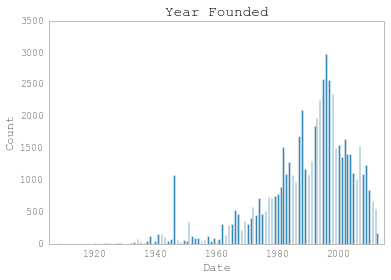

In [86]:
df.year_found.hist(bins=200)
plt.title("Year Founded")
plt.ylabel('Count')
plt.axis([1905, 2015, 0, 3500])
plt.xlabel('Date')

In [87]:
df['org_age'] = df['year'] - df['year_found']

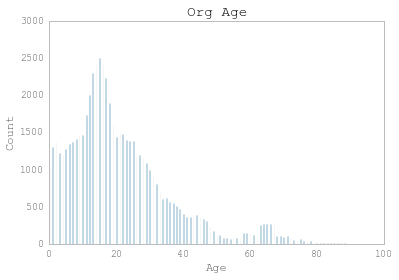

In [88]:
df.org_age.hist(bins=500)
plt.title("Org Age")
plt.ylabel('Count')
plt.axis([0, 100, 0, 3000])
plt.xlabel('Age')

In [89]:
df_condense = df[['NAME_x', 'NTEECC', 'city_lower', 'state_lower', 'INCOME', 'year_found', 'org_age']]

In [90]:
df_condense[df_condense.org_age > 80].sort('org_age', ascending=False).head(10)

,NAME_x,NTEECC,city_lower,state_lower,INCOME,year_found,org_age
5762,THE FORT WAYNE RESCUE MISSION MINISTRIES INC,L41,fort wayne,in,3514633,1908,105
17374,THE FORT WAYNE RESCUE MISSION MINISTRIES INC,L41,fort wayne,in,3411783,1908,104
28386,THE FORT WAYNE RESCUE MISSION MINISTRIES INC,L41,fort wayne,in,4896662,1908,103
42942,THE FORT WAYNE RESCUE MISSION MINISTRIES INC,L41,fort wayne,in,4896662,1908,102
56445,THE FORT WAYNE RESCUE MISSION MINISTRIES INC,L41,fort wayne,in,2523209,1908,101
33965,STAPELEY HALL,L22,philadelphia,pa,0,1914,96
5,CAMBRIDGE HOMES,S22,boston,ma,14679414,1918,95
47227,STAPELEY HALL,L22,philadelphia,pa,0,1914,95
10701,CAMBRIDGE HOMES,S22,boston,ma,6995609,1918,94
21789,CAMBRIDGE HOMES,S22,boston,ma,9440657,1918,93


In [91]:
age_by_city = df.groupby('city_lower').agg({'org_age': [np.size, np.median]})

In [92]:
print age_by_city.sort([('org_age', 'median')], ascending=False).head(10)

            org_age       
               size median
city_lower                
fremont          31   31.0
columbus       1944   27.0
cleveland       800   26.0
rochester       793   26.0
greensboro     1443   23.0
tampa           416   22.0
laredo           77   22.0
cincinnati      785   22.0
jersey city      32   21.5
amarillo         23   21.0


###Create new dataset of city characterstics (like the `collapse` command in Stata)

In [114]:
df['pct_minority'] = 1 - (df['White Alone'] / df['Total Population'])
df['poverty_rate'] = df['Families: Income in 2013 below poverty level'] / df['Families']
df['log_inc'] = df['INCOME'].apply(np.log)

In [115]:
df['voucher_use'] = df['voucher_use'].convert_objects(convert_numeric=True)

In [116]:
df['logvouchuse'] = df['voucher_use'].apply(np.log)

In [308]:
df.shape

(62423, 178)

In [117]:
advocacy_dummy = pd.get_dummies(df['NTEECC'], prefix='NTEECC')

In [118]:
df = df.join(advocacy_dummy.ix[:, 'NTEECC_L01'])

In [311]:
df['NTEECC_L01'].value_counts()

0    61955
1      468
dtype: int64

In [119]:
df['cdc_in_name'] = df.NAME_x.str.contains('COMMUNITY DEVELOPMENT') | df.NAME_x.str.contains('COMMUNITY DEVELOPMENT CORPORATION') | df.NAME_x.str.contains('CDC')

In [120]:
df['cdc'] = df['cdc_in_name'].astype(int)

In [121]:
city_df = df.groupby(['Place (State FIPS + Place FIPS)', 'city_lower', 'state_lower', 'year'], as_index=False)

In [122]:
city_df = city_df.agg({'EIN' : {'Number of Orgs': 'count'},
               'org_age' : {'Median Org Age (all orgs)':  'median'},
               'log_inc' : {'Median Log Income (all orgs)': 'median'},
               'NTEECC_L01' : {'Number of Advocacy Orgs': 'sum'},
               'cdc': {'Number of CDCs': 'sum'},
               'Total Population' : {'City Population': 'mean'},
               'pct_minority' : {'Percent Minority': 'mean'},
               'poverty_rate' : {'Poverty Rate': 'mean'},
               'Households: Gini Index' : {'Gini Index': 'mean'},
               'gdp_growth' : {'GDP Growth (metro area)': 'mean'},
               'total_units': {'Units Built' : 'mean'},
               'logvouchuse': {'Log Voucher Use': 'mean'}
              } )

In [123]:
city_df

,Place (State FIPS + Place FIPS),city_lower,state_lower,year,Total Population,cdc,log_inc,org_age,NTEECC_L01,total_units,gdp_growth,EIN,logvouchuse,pct_minority,poverty_rate,Households: Gini Index
,,,,,City Population,Number of CDCs,Median Log Income (all orgs),Median Org Age (all orgs),Number of Advocacy Orgs,Units Built,GDP Growth (metro area),Number of Orgs,Log Voucher Use,Percent Minority,Poverty Rate,Gini Index
0,107000,birmingham,al,2009,231486,3,10.835022,15.0,1,2971,-0.066228,125,4.521789,0.747453,0.211099,0.4870
1,107000,birmingham,al,2010,216392,3,11.279584,16.0,1,2971,0.032606,122,4.454347,0.770888,0.212195,0.4890
2,107000,birmingham,al,2011,214348,3,11.563400,17.0,1,2971,0.060244,99,4.465908,0.768311,0.224508,0.4893
3,107000,birmingham,al,2012,213180,3,11.844292,18.0,1,2971,0.063536,93,4.499810,0.772319,0.243358,0.4919
4,107000,birmingham,al,2013,212295,2,11.871592,19.0,1,2971,0.000234,83,4.499810,0.773217,0.248970,0.4970
5,150000,mobile,al,2009,191936,1,12.061117,15.5,0,2026,0.007594,70,4.465908,0.526530,0.183844,0.5100
6,150000,mobile,al,2010,195619,1,11.832578,15.0,0,2026,0.032351,71,4.330733,0.539707,0.179356,0.5110
7,150000,mobile,al,2011,195457,1,12.066029,15.0,0,2026,0.030506,71,4.406719,0.539003,0.181097,0.5087
8,150000,mobile,al,2012,195239,1,11.888285,18.5,0,2026,0.014974,76,4.343805,0.543877,0.185307,0.5052


###Comparable Stata code 

Here's the Stata code that would produce a similar output as the `city_df` dataframe above. It's a little less verbose, but not by much. 

    gen minority = 1 - (whitealone/totalpopulation)
    gen poverty = familiesincomein2013belowpoverty /families
    gen loginc = ln(income)
    gen logvouchuse = ln(voucher_use)
    gen cdc_1 = regexm(name_x, "COMMUNITY DEVELOPMENT")
    gen cdc_2 = regexm(name_x, "COMMUNITY DEVELOPMENT CORPORATION")
    gen cdc_3 = regexm(name_x, "CDC")
    gen cdc = 0
    replace cdc = 1 if cdc_1 == 1 | cdc_2 == 1 | cdc_3 == 1
    gen advocacy = nteecc == "L01"
    collapse (median)loginc (median)org_age (mean)logvouchuse (mean)logvouchpay (mean)total_units (count)ein (sum)coalition (sum)advocacy (sum)cdc (sum)low_income (sum)low_income_priority (mean)totalpopulation (mean)blackorafricanamericanalone (mean)medianhouseholdincomein2013infla (mean)householdsginiindex (mean)renteroccupiedpayingcashrentmedi (mean)gdp_growth (mean)minority (mean)poverty (mean)manager, by(city_main city_lower state_lower year)